In [5]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import csv
from numpy import genfromtxt
from scipy.spatial import distance
import os
import glob
from pylab import *
from matplotlib.pyplot import imread
import networkx as nx

In [6]:
def construct_M(height_pixels, width_pixels):
    fov_x = pi/3.0
    fov_y = 2.0 * arctan(height_pixels * tan(fov_x/2.0) / width_pixels)
    near  = 1.0
    far   = 1000.0

    f_h    = tan(fov_y/2.0)*near
    f_w    = f_h*width_pixels/height_pixels
    left   = -f_w
    right  = f_w
    bottom = -f_h
    top    = f_h

    M_proj      = matrix(zeros((4,4)))
    M_proj[0,0] = (2.0*near)/(right - left)
    M_proj[1,1] = (2.0*near)/(top - bottom)
    M_proj[0,2] = (right + left)/(right - left)
    M_proj[1,2] = (top + bottom)/(top - bottom)
    M_proj[2,2] = -(far + near)/(far - near)
    M_proj[3,2] = -1.0
    M_proj[2,3] = -(2.0*far*near)/(far - near)
    
    return M_proj

In [7]:
def world2screen_proj(p_world, camera_pos, camera_rot, height_pixels, width_pixels):
    R_cam2world = matrix(camera_rot)
    t_cam2world = matrix(camera_pos).T
    R_world2cam = R_cam2world.T
    t_world2cam = -R_world2cam*t_cam2world

    M = construct_M(height_pixels, width_pixels)

    p_cam      = t_world2cam + R_world2cam*p_world
    p_cam_     = matrix(r_[ p_cam.A1, 1 ]).T
    p_clip     = M * p_cam_
    p_ndc      = p_clip/p_clip[3]
    p_ndc_     = p_ndc.A1
    p_screen_x = 0.5*(p_ndc_[0]+1)*(width_pixels-1)
    p_screen_y = (1 - 0.5*(p_ndc_[1]+1))*(height_pixels-1)
    p_screen_z = (p_ndc_[2]+1)/2.0
    p_screen   = matrix([p_screen_x, p_screen_y, p_screen_z]).T
    
    return p_screen

In [8]:
def assign_labels(mesh_objects_sii, mesh_objects_si, metadata_objects, nyu_labels, bb_pos):
    bb_labels = []
    bb_error = []
    n_bb = bb_pos.shape[0] - 1
    nyu_id = np.zeros(n_bb)

    for i in range(n_bb):
        lowlvl_instances_in_current_bb = np.where(mesh_objects_sii == i+1)[0]
        if lowlvl_instances_in_current_bb.size > 0:
            nyu_id[i] = mesh_objects_si[lowlvl_instances_in_current_bb[0]]
            bb_labels.append(nyu_labels[int(nyu_id[i])][1])
        else:
           bb_error.append(i+1)
           bb_labels.append(np.nan) 
    
    return bb_labels, bb_error

In [9]:
def calculate_distance(threshold, a2m, bb_pos, bb_error):
    n_bb = bb_pos.shape[0] - 1
    bb_pos_m = bb_pos*a2m

    distances = np.zeros((n_bb, n_bb))
    distances[:, :] = np.nan

    for i in range(n_bb):
        for j in range(n_bb):
            if i+1 not in bb_error and j+1 not in bb_error:
                distances[i, j] = distance.euclidean(bb_pos_m[i+1, :], bb_pos_m[j+1, :])

    distance_mask = (distances <= threshold)*int(1) # True for objects that are within [threshold] m of other objects
    np.fill_diagonal(distance_mask, 0)
    
    return distance_mask

In [29]:
def construct_adjacency_matrix(n_bb, bb_in_sample, distance_mask):    
    # Array of BB to ignore in the adjacency matrix (not present in the graph)
    temp = arange(1, n_bb+1) # goes from 1 to 55
    bb_not_in_sample = np.delete(temp, bb_in_sample - np.ones(len(bb_in_sample), dtype=int))
    index = bb_not_in_sample - np.ones(len(bb_not_in_sample), dtype=int)
    
    adjacency_matrix = distance_mask
    adjacency_matrix[index,:] = np.zeros((len(bb_not_in_sample), n_bb))
    adjacency_matrix[:, index] = np.zeros((n_bb, len(bb_not_in_sample)))
    return adjacency_matrix

In [14]:
def plot_scene(n_bb, bb_pos, bb_in_sample, camera_pos, camera_rot, height_pixels, width_pixels, adjacency_matrix, bb_labels, tonemap):

    # Attribute label to each graph node from the constructed labels for the scene
    temp = arange(1, n_bb+1)
    bb_not_in_sample = np.delete(temp, bb_in_sample - np.ones(len(bb_in_sample), dtype=int))
    bb_in_sample_nodes = np.delete(temp, bb_not_in_sample - np.ones(len(bb_not_in_sample), dtype=int))
    node_labels_dict = {}
    for i in bb_in_sample_nodes:
        node_labels_dict[i] = bb_labels[i-1]

    # Calculate 2-D postions of BB centres (for graphing)
    bb_pos_nodes = {}
    for i in bb_in_sample:
        bb_pos_ = expand_dims(bb_pos[i], 1) # homogenous coordinates
        bb_pos_nodes_screen = world2screen_proj(bb_pos_, camera_pos, camera_rot, height_pixels, width_pixels)

        x = np.ravel(bb_pos_nodes_screen[0])
        x = x.astype(int)
        x = x.item()
        x = np.clip(x, 0, width_pixels)

        y = np.ravel(bb_pos_nodes_screen[1])
        y = y.astype(int)
        y = y.item()
        y = - y + height_pixels
        y = np.clip(y, 0, height_pixels)

        bb_pos_nodes[i] = (x, y)
    
    # Define graph
    rows, cols = np.where(adjacency_matrix == 1)
    rows = rows + 1
    cols = cols + 1
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()

    gr.add_nodes_from(bb_in_sample)
    gr.add_edges_from(edges)

    y_lim, x_lim = tonemap.shape[:-1]
    extent = 0, x_lim, 0, y_lim

    fig = plt.figure(figsize=(10,10))
    plt.imshow(tonemap, extent=extent, interpolation='nearest')
    nx.draw(gr, pos=bb_pos_nodes, node_size=50, with_labels=True, labels=node_labels_dict, font_size=10)
    plt.show()

    return None

In [17]:
def import_scene(scene_name, scene_dir):
    detail_dir = os.path.join(scene_dir, "_detail")

    bb_size_dir = os.path.join(detail_dir, "mesh", "metadata_semantic_instance_bounding_box_object_aligned_2d_extents.hdf5")
    bb_pos_dir = os.path.join(detail_dir, "mesh", "metadata_semantic_instance_bounding_box_object_aligned_2d_positions.hdf5")
    bb_rot_dir = os.path.join(detail_dir, "mesh", "metadata_semantic_instance_bounding_box_object_aligned_2d_orientations.hdf5")

    mesh_objects_si_dir = os.path.join(ml_hypersim_dir, "evermotion_dataset", "scenes", scene_name, "_detail", "mesh", "mesh_objects_si.hdf5")
    mesh_objects_sii_dir = os.path.join(ml_hypersim_dir, "evermotion_dataset", "scenes", scene_name, "_detail", "mesh", "mesh_objects_sii.hdf5")
    metadata_objects_dir = os.path.join(ml_hypersim_dir, "evermotion_dataset", "scenes", scene_name, "_detail", "mesh", "metadata_objects.csv")
    a2m_dir = os.path.join(detail_dir, "metadata_scene.csv")

    with h5py.File(bb_size_dir, "r") as f: bb_sizes = f['dataset'][:]
    with h5py.File(bb_rot_dir, "r") as f: bb_rot = f['dataset'][:]
    with h5py.File(bb_pos_dir, "r") as f: bb_pos = f['dataset'][:]

    with h5py.File(mesh_objects_si_dir, "r") as f: mesh_objects_si = f['dataset'][:]
    with h5py.File(mesh_objects_sii_dir, "r") as f: mesh_objects_sii = f['dataset'][:]
    metadata_objects = genfromtxt(metadata_objects_dir, delimiter=None, dtype=str)

    with open(a2m_dir, newline='') as csvfile:
        metadata_scene = list(csv.reader(csvfile))
        a2m = float(metadata_scene[1][1])
    
    return bb_sizes, bb_rot, bb_pos, mesh_objects_si, mesh_objects_sii, metadata_objects, a2m

In [18]:
def import_nyu_labels(ml_hypersim_dir):
    nyu_labels_dir = os.path.join(ml_hypersim_dir, "code", "cpp", "tools", "scene_annotation_tool", "semantic_label_descs.csv")
    nyu_labels = genfromtxt(nyu_labels_dir, delimiter=',', dtype=None, encoding=None, autostrip=True)
    return nyu_labels

In [19]:
def import_camera(scene_dir, camera_name):
    detail_dir = os.path.join(scene_dir, "_detail")
    camera_pos_dir = os.path.join(detail_dir, camera_name, "camera_keyframe_positions.hdf5")
    camera_rot_dir = os.path.join(detail_dir, camera_name, "camera_keyframe_orientations.hdf5")
    with h5py.File(camera_pos_dir, "r") as f: camera_pos_all = f['dataset'][:]
    with h5py.File(camera_rot_dir, "r") as f: camera_rot_all = f['dataset'][:]
    return camera_pos_all, camera_rot_all

In [20]:
def import_frame(tonemap_dir, segmentation_dir):
    tonemap = imread(tonemap_dir)
    with h5py.File(segmentation_dir, "r") as f: segmentation = f['dataset'][:]
    return tonemap, segmentation

0 loaded frame.0000.tonemap.jpg and frame.0000.semantic_instance.hdf5


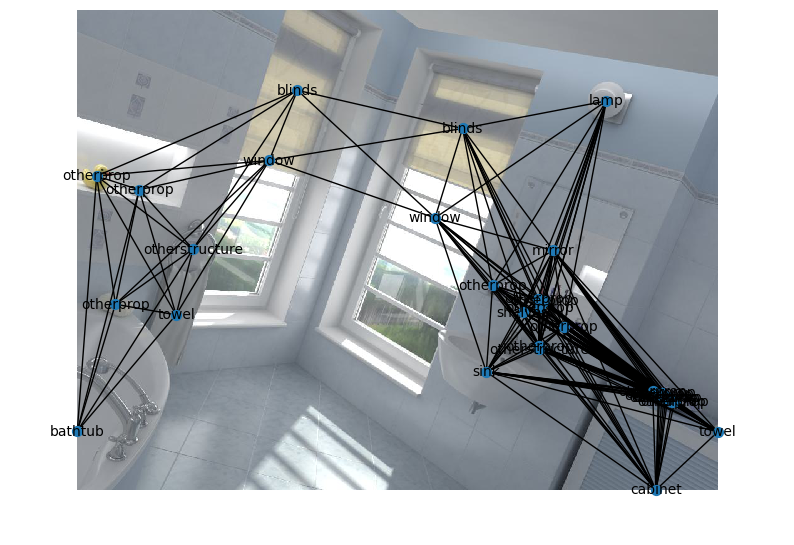

In [31]:
############ ARGS #############
ml_hypersim_dir = r"C:\Users\amali\Documents\ds_research\ml-hypersim"
download_dir = r"C:\Users\amali\Documents\ds_research\ml-hypersim\contrib\99991\downloads"
scene_name = r"ai_001_001" # TODO (alternatively, could add number of scenes to process, or 'ALL')
camera_name = r"cam_00" # TODO (alternatively, could add number of cameras to process, or 'ALL')
n_frames = 1 # number of frames to process
###############################

scene_dir = os.path.join(download_dir, scene_name)
images_dir = os.path.join(scene_dir, "images") # frame
preview_files_dir = os.path.join(images_dir, "scene_" + camera_name + "_final_preview") # frame
geometry_files_dir = os.path.join(images_dir, "scene_" + camera_name + "_geometry_hdf5") # frame

# Import scene- and camera-specific files
bb_sizes, bb_rot, bb_pos, mesh_objects_si, mesh_objects_sii, metadata_objects, a2m = import_scene(scene_name, scene_dir)
nyu_labels = import_nyu_labels(ml_hypersim_dir)
camera_pos_all, camera_rot_all = import_camera(scene_dir, camera_name)

#### Assign a label to each BB (scene-specific assignment)
n_bb = bb_pos.shape[0] - 1
bb_labels, bb_error = assign_labels(mesh_objects_sii, mesh_objects_si, metadata_objects, nyu_labels, bb_pos)

# Frame-specific files
tonemap_files_dir = os.path.join(images_dir, "scene_" + camera_name + "_final_preview", "frame.*.tonemap.jpg")
segmentation_files_dir = os.path.join(images_dir, "scene_" + camera_name + "_geometry_hdf5", "frame.*.semantic_instance.hdf5")

filenames_tonemap = [ os.path.basename(f) for f in sort(glob.glob(tonemap_files_dir)) ]
filenames_segmentation = [ os.path.basename(f) for f in sort(glob.glob(segmentation_files_dir)) ]

# Calculate Euclidian distance between nodes and compare to threshold value
# Only need to calculate the distance mask once for every scene
threshold = 1.5
distance_mask = calculate_distance(threshold, a2m, bb_pos, bb_error)

# Iterate through frames (given scene and camera):
for tonemap_file, segmentation_file, frame_id in zip(filenames_tonemap[:n_frames], filenames_segmentation[:n_frames], arange(n_frames)):
    tonemap_dir = os.path.join(preview_files_dir, tonemap_file)
    segmentation_dir =  os.path.join(geometry_files_dir, segmentation_file)

    # Load tonemap and segmentation for current frame
    tonemap, segmentation = import_frame(tonemap_dir, segmentation_dir)
    print(frame_id, "loaded", tonemap_file, "and", segmentation_file)

    # Select BB that are present in current frame
    bb_in_sample = unique(segmentation)
    if bb_in_sample[0] == -1:
        bb_in_sample = bb_in_sample[1:] # discard -1 label (pixels in segmentation map with unidentified BB)
    n_bb_in_sample = bb_in_sample.shape[0]

    # Construct adjacency matrix
    adjacency_matrix = construct_adjacency_matrix(n_bb, bb_in_sample, distance_mask)

    # Plot labelled BB as graph on top of tonemap
    # First, calculate frame-specific variables (image size and camera placement for current frame)
    height_pixels = tonemap.shape[0] 
    width_pixels  = tonemap.shape[1]
    camera_pos = camera_pos_all[frame_id]
    camera_rot = camera_rot_all[frame_id]
    # Then, plot
    plot_scene(n_bb, bb_pos, bb_in_sample, camera_pos, camera_rot, height_pixels, width_pixels, adjacency_matrix, bb_labels, tonemap)
    if n_frames > 1:
        plt.show()